Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
'''
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')
'''

"\n# If you're in Colab...\nimport os, sys\nin_colab = 'google.colab' in sys.modules\n\nif in_colab:\n    # Install required python packages:\n    # category_encoders, version >= 2.0\n    # pandas-profiling, version >= 2.0\n    # plotly, version >= 4.0\n    !pip install --upgrade category_encoders pandas-profiling plotly\n    \n    # Pull files from Github repo\n    os.chdir('/content')\n    !git init .\n    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git\n    !git pull origin master\n    \n    # Change into directory for module\n    os.chdir('module3')\n"

In [2]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [3]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [4]:
df.shape

(23040, 21)

In [5]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,...,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,...,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,...,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,...,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,...,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [6]:
df.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int32
SALE_DATE                          object
dtype: object

In [7]:
df.isna().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [8]:
drop_list = [
    'APARTMENT_NUMBER',
    'EASE-MENT',
    'ADDRESS'
]
df = df.drop(columns=drop_list)

In [9]:
dfa = df[df.BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS'].copy()

In [10]:
# Investigate opportunities for encoding
potential_cats = [
    'NEIGHBORHOOD',
    'BUILDING_CLASS_CATEGORY',
    'TAX_CLASS_AT_PRESENT',
    'BUILDING_CLASS_AT_PRESENT', 
    'BUILDING_CLASS_AT_TIME_OF_SALE',
]
dfa[potential_cats].nunique()

NEIGHBORHOOD                      213
BUILDING_CLASS_CATEGORY             1
TAX_CLASS_AT_PRESENT                3
BUILDING_CLASS_AT_PRESENT          16
BUILDING_CLASS_AT_TIME_OF_SALE     12
dtype: int64

In [11]:
dfa[potential_cats].isna().sum()

NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BUILDING_CLASS_AT_PRESENT         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
dtype: int64

In [12]:
# drop nan values within the category class
drop_list = [
    22943,    
]
#dfa = dfa.drop(drop_list)
dfa[potential_cats].isna().sum()

NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BUILDING_CLASS_AT_PRESENT         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
dtype: int64

In [13]:
dfa[potential_cats].shape

(5061, 5)

In [14]:
dfa.NEIGHBORHOOD[0:10]

7     MORRIS PARK/VAN NEST
8     MORRIS PARK/VAN NEST
9     MORRIS PARK/VAN NEST
42                 MADISON
44     OCEAN PARKWAY-NORTH
48                 BAYSIDE
55          MIDDLE VILLAGE
61          QUEENS VILLAGE
63           SOUTH JAMAICA
78    PELHAM PARKWAY SOUTH
Name: NEIGHBORHOOD, dtype: object

In [15]:
# All seem good to encode.  Note: sklearn's OneHotEncoder will return a sparse matrix that can't be used directly.
# pd.get_dummies...

hot_encoded_cats = pd.get_dummies(dfa[potential_cats],)
dfa = dfa.drop(columns=potential_cats)
dfa.shape

(5061, 13)

In [16]:
dfa = dfa.join(hot_encoded_cats)
dfa.shape

(5061, 258)

In [17]:
# Encode sales date as date_time
dfa['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

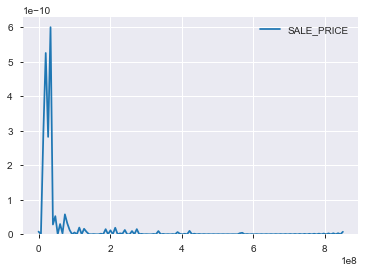

In [18]:
# Quick look at price
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax = sns.kdeplot(df.SALE_PRICE)

In [19]:
# Something is wrong with price.  It being high at zero doesn't make a lot of sense unless the home hasn't sold.
dfa.SALE_PRICE.describe()

count    5.061000e+03
mean     4.718425e+05
std      9.288682e+05
min      0.000000e+00
25%      0.000000e+00
50%      4.280000e+05
75%      6.400000e+05
max      3.013936e+07
Name: SALE_PRICE, dtype: float64

In [20]:
# 850 million seems a bit nuts.  So does zero.  Let's look at 1% low and 99% highs
from IPython.display import display
display(dfa.SALE_PRICE.quantile(0.30), dfa.SALE_PRICE.quantile(0.95))
dfa[
    (dfa.SALE_PRICE < dfa.SALE_PRICE.quantile(0.05)) |
    (dfa.SALE_PRICE > dfa.SALE_PRICE.quantile(0.95))
].SALE_PRICE.count()

0.0

1165000.0

253

In [21]:
# Dropping 7,140 datapoints is a bit much, almost a third of the data or potentially half of the training set.  The zeroes can definitely become NaNs.
dfa.query('SALE_PRICE == 0').SALE_DATE.count()

1681

In [22]:
# Well, that's interesting.  I'm not sure there's too much point at this time keeping the data for the 0.00 homes around.
# Per instructions, we can cull a lot of data
dfa = dfa.query('SALE_PRICE > 100000')
dfa = dfa.query('SALE_PRICE < 2000000')

In [23]:
dfa.shape

(3151, 258)

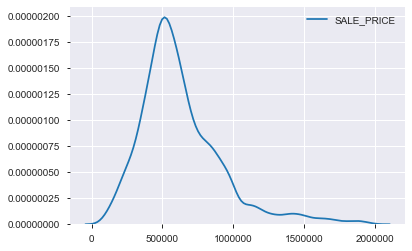

count    3.151000e+03
mean     6.285601e+05
std      2.929904e+05
min      1.040000e+05
25%      4.475000e+05
50%      5.680000e+05
75%      7.600000e+05
max      1.955000e+06
Name: SALE_PRICE, dtype: float64

In [24]:
# Run the kernel density plot one more time
fig, ax = plt.subplots()
ax = sns.kdeplot(dfa.SALE_PRICE)
plt.show()

dfa.SALE_PRICE.describe()

In [25]:
import numpy as np
dfa.describe(exclude=np.number)

,LAND_SQUARE_FEET,SALE_DATE
count,3151,3151
unique,1035,91
top,"4,000",2019-01-31 00:00:00
freq,289,78
first,NaN,2019-01-01 00:00:00
last,NaN,2019-04-30 00:00:00


In [26]:
# Need to transform LAND_SQUARE_FEET to int
dfa['LAND_SQUARE_FEET'] = dfa.LAND_SQUARE_FEET.str.replace(',','').astype(int)

In [27]:
dfa.LAND_SQUARE_FEET.describe()

count     3151.000000
mean      3112.117423
std       1790.055434
min          0.000000
25%       2000.000000
50%       2542.000000
75%       4000.000000
max      18906.000000
Name: LAND_SQUARE_FEET, dtype: float64

In [28]:
# Quick investigation of zero land squre feet
dfa.query('LAND_SQUARE_FEET == 0').head()

,BOROUGH,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,...,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A7,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_S0,BUILDING_CLASS_AT_TIME_OF_SALE_S1
1135,4,16340,50,11697.0,0.0,0.0,0.0,0,0.0,1938.0,...,0,0,0,0,0,0,1,0,0,0
1403,4,16340,50,11697.0,0.0,0.0,0.0,0,0.0,1938.0,...,0,0,0,0,0,0,1,0,0,0
1990,4,16340,50,11697.0,0.0,0.0,0.0,0,0.0,1938.0,...,0,0,0,0,0,0,1,0,0,0
1991,4,16350,400,11697.0,0.0,0.0,0.0,0,0.0,1938.0,...,0,0,0,0,0,0,1,0,0,0
2469,2,5507,1,10465.0,0.0,0.0,0.0,0,0.0,1921.0,...,0,0,0,0,0,0,1,0,0,0


In [29]:
# Not sure what's going on with these, but I'd rather not try to impute either missing values or find out why they are 0.
dfa = dfa.query('LAND_SQUARE_FEET > 0')
dfa.shape

(3111, 258)

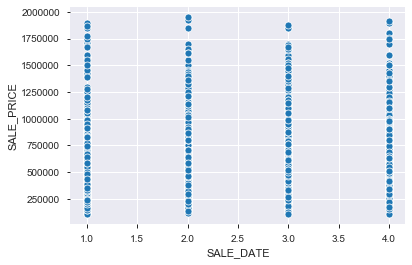

In [30]:
# SALES_DATE might be an important feature. Let's take a quick look, because I want to drop it rather than try to encode to numeric
sns.scatterplot(x=dfa.SALE_DATE.dt.month, y='SALE_PRICE', data=dfa)

**I think it's safe to drop by visual inspection.  The timeframe is also very condensed - if we had a whole year, it would make more sense.**


In [31]:
# Manually split into test/train sets
test_data = dfa[dfa.SALE_DATE.dt.month == 4].drop(columns='SALE_DATE')
training_data = dfa[dfa.SALE_DATE.dt.month.isin(range(1,4))].drop(columns='SALE_DATE')
display(test_data.shape, training_data.shape)

(635, 257)

(2476, 257)

In [32]:
# This is potentially a good spot to start feature selection, standardization (where necessary), and regression
target = 'SALE_PRICE'

def return_feat_target(df, target):
    return df.drop(columns=target), df[target]


X_train, y_train = return_feat_target(training_data, target)
X_test, y_test = return_feat_target(test_data, target)
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2476, 256)

(2476,)

(635, 256)

(635,)

In [45]:
# Run model
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings(action='ignore', category=RuntimeWarning)

def linear_pipe(X_train, y_train, X_test, y_test, num_features):
    '''
    Select a number of features for SelectKBest to return.
    Scale features with RobustScalar
    Passes scaled features to linear model and fitted model
    
    Inputs:
    X_train, y_train: Pandas DataFrame of feature training set and corresponding target set
    X_test, y_test: Pandas DataFrame of feature test set and corresponding target set
    num_features: integer number of features to pass to model
    
    Return fitted model
    '''
    def select_features(**kw):
        # Create Selector and fit to training data
        selector = SelectKBest(f_regression, k=num_features)
        selector.fit(X_train, y_train)
        # Get columns to keep
        cols = selector.get_support(indices=True)
        # Create subsets of training and test data, return values
        return X_train.iloc[:, lambda df: cols],  X_test.iloc[:, lambda df: cols]
    
    def scale_features(X_train_selected, X_test_selected):
        # Create scalar
        scaler = RobustScaler()
        # Scale & Transform Features, return value
        scaler.fit(X_train_selected.to_numpy())
        return scaler.transform(X_train_selected.to_numpy()), scaler.transform(X_test_selected.to_numpy())
    
    def generate_model(features, target):
        regr = linear_model.LinearRegression()
        return regr.fit(features, target)
    
    def evaluate_model(model, X_test_selected):
        y_pred = model.predict(X_test_selected)
        eval_info = {
            'coefficients': model.coef_,
            'mse': mean_squared_error(y_test, y_pred),
            'r2': r2_score(y_test, y_pred)
        }
        return eval_info
        
        
    
    X_train_selected, X_test_selected = select_features()
    X_train_scaled, X_test_scaled = scale_features(X_train_selected, X_test_selected)
    model = generate_model(features=X_train_scaled, target=y_train)
    eval_info = evaluate_model(model, X_test_scaled)
    
    return model, eval_info
    
    


In [47]:
_, info = linear_pipe(X_train, y_train, X_test, y_test, 2)
info

{'coefficients': array([ 40558.37986598, 110073.10768369]),
 'mse': 67842203721.260345,
 'r2': 0.22021951472359935}

In [90]:
from math import log
model_evals = []
for i in range(1,30):
    _, info = linear_pipe(X_train, y_train, X_test, y_test, i)
    model_evals.append([info['r2'], info['mse']])
    
model_evals = pd.DataFrame(model_evals)

lowest MSE: 51703750720.76791


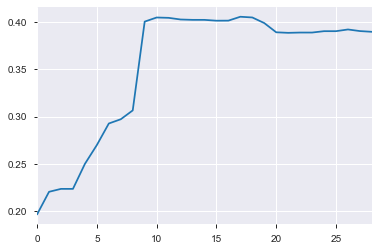

In [96]:
model_evals[0].plot()
print('lowest MSE:', model_evals[1].min())

**I really like the pipeline.  It seems to be working and I could easily adjust it to print the feature columns.  Unfortunately, it looks like we plataeu a little below 0.40 without optimization or further cleaning.  Just to see, what was the baseline prediction?**

In [69]:
# Testing the mean
y_pred = [y_test.mean()]*len(y_test)
display(mean_squared_error(y_test, y_pred),
       r2_score(y_test, y_pred)
       )

87001669062.30415

0.0